# 多模態寵物照護 RAG 系統 v2
## 1. 導入必要套件

In [1]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np
from IPython.display import Image, display

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image as PILImage

# LLM
from vertexai.generative_models import GenerativeModel, Part, Image as VertexImage
import vertexai

# PDF處理
import PyPDF2

# 設置日誌
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 檢查並創建必要的目錄
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

/Users/zirong/miniforge3/envs/llm/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## 2. Embedding 處理模組

In [22]:

class HybridEmbeddingProcessor:
    def __init__(self, 
                 persist_directory: str = "chroma_db",
                 image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        
        # 初始化文本 embedding 模型 - 使用更適合長文本的模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')  # 768維，更好的文本理解
        
        # 初始化 CLIP 模型 - 專門用於圖片
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 設置 Chroma
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 創建兩個不同的集合，使用不同的 embedding 函數
        try:
            self.chroma_client.delete_collection("text_documents")
            self.chroma_client.delete_collection("image_documents")
        except:
            pass
        
        # 文本集合使用 SentenceTransformer
        self.text_collection = self.chroma_client.create_collection(
            name="text_documents",
            embedding_function=embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name='all-mpnet-base-v2'
            )
        )
        
        # 圖片集合使用自定義的 CLIP embedding 函數
        def clip_embedding_function(images):
            # 這個函數不會被直接使用，因為我們會直接提供embeddings
            pass
        
        self.image_collection = self.chroma_client.create_collection(
            name="image_documents"
        )
        
        logger.info("Initialized hybrid embedding system")
    
    def process_image(self, image_path: str) -> Optional[np.ndarray]:
        """使用 CLIP 處理圖片"""
        try:
            image = PILImage.open(image_path)
            inputs = self.clip_processor(images=image, return_tensors="pt")
            image_features = self.clip_model.get_image_features(**inputs)
            embedding = image_features.detach().numpy()[0]
            embedding = embedding / np.linalg.norm(embedding)
            return embedding
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None

    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info(f"Added {len(texts)} text documents")
            
            # 處理並添加圖片
            if images:
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info(f"Added {len(valid_images)} images")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}")
            raise
    def calculate_image_relevance(self, query: str) -> float:
        """評估查詢是否需要圖片"""
        # 視覺相關關鍵詞
        visual_keywords = {
            "環境": 1.0,
            "佈置": 1.0,
            "擺設": 1.0,
            "空間": 1.0,
            "設計": 1.0,
            "擺放": 1.0,
            "輪椅": 1.0,
            "器材": 1.0,
            "設施": 1.0,
            "游泳池": 1.0,
            "活動區": 1.0
        }
        
        # 症狀觀察關鍵詞（較低權重）
        symptom_keywords = {
            "姿勢": 0.5,
            "表現": 0.5,
            "狀態": 0.5,
            "行為": 0.5,
            "動作": 0.5,
            "症狀": 0.3,
            "走路": 0.5,
            "站立": 0.5,
            "臥躺": 0.5
        }
        
        # 計算加權分數
        score = 0.0
        for keyword, weight in {**visual_keywords, **symptom_keywords}.items():
            if keyword in query:
                score += weight
        
        # 正規化分數到 0-1
        return min(score / 2, 1.0)

    def search(self, 
             query: str, 
             k: int = 3, 
             image_threshold: float = 0.3) -> Dict:
        """改進的混合搜索"""
        try:
            # 評估是否需要圖片
            image_relevance = self.calculate_image_relevance(query)
            logger.info(f"Image relevance score for query '{query}': {image_relevance}")
            
            # 文本搜索
            text_results = self.text_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 圖片搜索
            image_results = {
                "metadatas": [],
                "documents": [],
                "distances": [],
                "ids": []
            }
            
            if image_relevance >= image_threshold:
                # 使用CLIP的文本編碼器處理查詢
                inputs = self.clip_processor(
                    text=[query], 
                    return_tensors="pt", 
                    padding=True
                )
                text_features = self.clip_model.get_text_features(**inputs)
                query_embedding = text_features.detach().numpy()[0]
                query_embedding = query_embedding / np.linalg.norm(query_embedding)
                
                image_results = self.image_collection.query(
                    query_embeddings=[query_embedding.tolist()],
                    n_results=k
                )
            
            return {
                "texts": text_results,
                "images": image_results,
                "image_relevance": image_relevance
            }
            
        except Exception as e:
            logger.error(f"Search error: {str(e)}")
            return {
                "texts": {
                    "ids": [], 
                    "documents": [], 
                    "metadatas": [], 
                    "distances": []
                },
                "images": {
                    "ids": [], 
                    "documents": [], 
                    "metadatas": [], 
                    "distances": []
                },
                "image_relevance": 0.0
            }

    
    def display_search_results(self, query: str, k: int = 3):
        """改進的結果顯示"""
        results = self.search(query, k)
        
        print(f"Query: {query}\n")
        
        # 顯示文本結果
        print("Text Results:")
        if results["texts"]["documents"]:
            for i, (doc, meta) in enumerate(zip(
                results["texts"]["documents"][0],
                results["texts"]["metadatas"][0]
            ), 1):
                print(f"\n{i}. Type: {meta['type']}")
                print(f"Content: {doc[:200]}...")
                if 'responses' in meta:
                    print(f"Responses: {len(meta['responses'].split('|'))} replies")
                if 'link' in meta:
                    print(f"Link: {meta['link']}")
        else:
            print("No text results found")
            
        # 顯示圖片結果
        print("\nImage Results:")
        if results["image_relevance"] >= 0.3 and results["images"]["metadatas"]:
            for i, meta in enumerate(results["images"]["metadatas"][0], 1):
                print(f"\n{i}. Image: {meta['path']}")
                if 'associated_text' in meta:
                    print(f"Associated text: {meta['associated_text'][:200]}...")
        else:
            if results["image_relevance"] < 0.3:
                print("Query not relevant for images")
            else:
                print("No relevant images found")
        
        print(f"\nImage Relevance Score: {results['image_relevance']:.2f}")

## 3. 資料處理模組

In [20]:
class DataProcessor:
    def __init__(self, embedding_processor: EmbeddingProcessor):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[str], List[Dict], List[str]]:
        """處理 CSV 並提取圖片，確保 metadata 值都是基本類型"""
        logger.info(f"Processing CSV: {csv_path}")
        texts = []
        metadatas = []
        images = []
        
        df = pd.read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_metadata = None
        
        for _, row in df.iterrows():
            # 開始新的貼文
            if pd.notna(row['post']):
                if current_post is not None:
                    # 保存前一個貼文
                    text = f"{current_post} {' '.join(current_responses)}"
                    texts.append(text)
                    if current_images:
                        current_metadata["images"] = ",".join(current_images)
                        images.extend(current_images)
                    # 將回應列表轉換為字符串，使用 | 作為分隔符
                    current_metadata["responses"] = "|".join(current_responses)
                    metadatas.append(current_metadata)
                
                # 初始化新貼文
                current_post = row['post']
                current_responses = []
                current_images = []
                current_metadata = {
                    "type": "social_post",
                    "source": "facebook",
                    "is_post": True,
                    "original_post": current_post
                }
                
                # 添加連結（如果有）
                if pd.notna(row['link']):
                    current_metadata["link"] = row['link']
            
            # 添加回覆
            if pd.notna(row['responses']):
                current_responses.append(row['responses'])
                
            # 處理圖片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最後一個貼文
        if current_post is not None:
            text = f"{current_post} {' '.join(current_responses)}"
            texts.append(text)
            if current_images:
                current_metadata["images"] = ",".join(current_images)
                images.extend(current_images)
            # 將回應列表轉換為字符串
            current_metadata["responses"] = "|".join(current_responses)
            metadatas.append(current_metadata)
        
        # 顯示處理結果的詳細資訊
        for i, (text, meta) in enumerate(zip(texts, metadatas)):
            logger.info(f"\nPost {i+1}:")
            logger.info(f"Content: {text[:100]}...")
            logger.info(f"Images: {meta.get('images', 'No images')}")
            # 使用 split('|') 代替 split('\n')
            logger.info(f"Responses: {len(meta.get('responses', '').split('|'))} replies")
            logger.info(f"Link: {meta.get('link', 'No link')}")
        
        return texts, metadatas, images

    def process_pdf(self, pdf_path: str) -> List[Dict]:
        """處理 PDF 文件，確保 metadata 值都是基本類型"""
        logger.info(f"Processing PDF: {pdf_path}")
        documents = []
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    for para in paragraphs:
                        documents.append({
                            'content': para,
                            'metadata': {
                                'source': pdf_path,
                                'page': str(page_num + 1),  # 轉換為字符串
                                'type': 'pdf',
                                'content_length': str(len(para))  # 添加額外信息，也確保是字符串
                            }
                        })
            
            logger.info(f"Extracted {len(documents)} paragraphs from PDF")
            return documents
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_path}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_path: str):
        """處理所有資料，確保所有 metadata 正確"""
        logger.info("Starting to process all documents...")
        
        try:
            # 處理 CSV 和圖片
            texts, metadatas, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nFound {len(images)} images:")
            for img in images:
                logger.info(f"- {img}")
            
            # 檢查圖片文件是否存在
            image_dir = Path("image")
            valid_images = []
            for img in images:
                img_path = image_dir / img
                if img_path.exists():
                    logger.info(f"Image file exists: {img_path}")
                    valid_images.append(img)
                else:
                    logger.error(f"Image file not found: {img_path}")
            
            # 處理 PDF
            pdf_docs = self.process_pdf(pdf_path)
            texts.extend([doc['content'] for doc in pdf_docs])
            metadatas.extend([doc['metadata'] for doc in pdf_docs])
            
            logger.info(f"\nProcessing summary:")
            logger.info(f"- Total texts: {len(texts)}")
            logger.info(f"- Total valid images: {len(valid_images)}")
            
            # 最終檢查確保所有 metadata 值都是基本類型
            for meta in metadatas:
                for key, value in list(meta.items()):
                    if isinstance(value, (list, dict)):
                        meta[key] = str(value)
            
            # 添加到 Chroma
            self.embedding_processor.add_documents(
                texts=texts,
                metadatas=metadatas,
                images=valid_images
            )
            
            logger.info(f"Successfully processed all documents")
            return len(texts), len(valid_images)
            
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise


## 4. QA系統模組

In [5]:

class QASystem:
    def __init__(self,
                 embedding_processor: HybridEmbeddingProcessor,
                 project_id: str,
                 location: str = "us-central1"):
        self.embedding_processor = embedding_processor
        self.init_llm(project_id, location)
        
    def init_llm(self, project_id: str, location: str):
        """初始化 Gemini"""
        vertexai.init(project=project_id, location=location)
        self.llm = GenerativeModel('gemini-1.0-pro-vision-001')
    
    def generate_response(self, query: str) -> Tuple[str, List[VertexImage]]:
        """改進的回應生成"""
        # 搜索相關內容
        search_results = self.embedding_processor.search(query)
        image_relevance = search_results["image_relevance"]
        
        # 根據不同的情況使用不同的提示模板
        if image_relevance >= 0.3:
            prompt = f"""你是一位專業的獸醫師，專精於寵物醫療和行為諮詢。
這個問題與環境設置或視覺觀察相關，請特別注意參考提供的圖片資訊。

參考資料：
{self.format_context(search_results)}

用戶問題：{query}

請提供專業且具體的建議，並：
1. 詳細描述相關圖片內容及其啟發
2. 解釋如何將圖片中的方案應用到實際情況
3. 引用參考資料來源（醫學文獻/社群討論）
4. 如涉及醫療建議，提醒諮詢獸醫"""
        else:
            prompt = f"""你是一位專業的獸醫師，專精於寵物醫療和行為諮詢。
這個問題主要與醫療或行為建議相關。

參考資料：
{self.format_context(search_results)}

用戶問題：{query}

請提供專業且具體的建議，並：
1. 根據醫學文獻提供專業解釋
2. 引用社群經驗作為輔助參考
3. 如有必要，提供具體的照護建議
4. 提醒需要就醫評估的情況"""

        # 準備內容
        contents = [prompt]
        vertex_images = []
        
        # 只在相關時添加圖片
        if image_relevance >= 0.3 and search_results["images"]:
            for metadata in search_results["images"]["metadatas"][0]:
                img_path = self.embedding_processor.image_dir / metadata["path"]
                if img_path.exists():
                    image = VertexImage.load_from_file(str(img_path))
                    contents.append(image)
                    vertex_images.append(image)
        
        # 生成回應
        response = self.llm.generate_content(contents)
        return response.text, vertex_images

    def format_context(self, search_results: Dict) -> str:
        """格式化上下文"""
        context = ""
        
        # 添加文本結果
        for doc, meta in zip(
            search_results["texts"]["documents"][0],
            search_results["texts"]["metadatas"][0]
        ):
            if meta["type"] == "pdf":
                context += f"【醫學文獻】\n{doc}\n\n"
            else:
                context += f"【社群討論】\n{doc}\n"
                if meta.get("link"):
                    context += f"來源：{meta['link']}\n\n"
        
        # 只在相關時添加圖片資訊
        if search_results["image_relevance"] >= 0.3:
            context += "\n【相關圖片】\n"
            for meta in search_results["images"].get("metadatas", [{}])[0]:
                context += f"- {meta['path']}\n"
        
        return context

    def display_response(self, query: str):
        """顯示回應"""
        response_text, images = self.generate_response(query)
        
        print("問題：", query)
        if images:
            print("\n相關圖片：")
            for img in images:
                display(img)
        
        print("\nGemini的回答：")
        print(response_text)
        print("\n" + "-"*50 + "\n")


## 5. 系統初始化和資料處理

In [23]:
embedding_processor = HybridEmbeddingProcessor()
data_processor = DataProcessor(embedding_processor)

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response.csv",
    pdf_path="salvin2010.pdf"
)

# 測試搜索
embedding_processor.display_search_results(
    "狗狗失智的症狀有哪些？",
    k=3
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Initialized hybrid embedding system
INFO:__main__:Starting to process all documents...
INFO:__main__:Processing CSV: post_response.csv
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:
Post 1:
INFO:__main__:Content: 失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。 輪椅不能...
INFO:__main__:Images: image01.jpg,image02.jpg,image03.jpg
INFO:__main__:Responses: 7 replies
INFO:__main__:Link: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/
INFO:__main__:
Post 2:
INFO:__main__:Content: 吃老狗失智夜晚狂叫，有何妙方？ 請醫生開立輕微鎮靜的藥，不要覺得捨不得，狗狗一直叫沒有休息也是不行的，主人更應該得到好的睡眠才能照顧好寶貝 白天盡量多散步、或是在家裡陪他活動，請醫生開保健品、嚴重的時...
INFO:__main__:Images: No images
INFO:__ma

Query: 狗狗失智的症狀有哪些？

Text Results:

1. Type: social_post
Content: 關於犬失智有問題想請益
上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。
1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？
2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因...
Responses: 5 replies
Link: https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/

2. Type: social_post
Content: 失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。 輪椅不能坐太久
最多半小時
也不要讓狗狗在上面睡覺會不舒服血液不循環
容易不小心就走了 如果不坐車嘅時候，就用頸圈保護，行路跌低也不會損害頭部 有時候看到狗狗站不起來又加上暈眩，彎著身體一直喘氣流口水，不好入...
Responses: 7 replies
Link: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/

3. Type: social_post
Content: 吃老狗失智夜晚狂叫，有何妙方？ 請醫生開立輕微鎮靜的藥，不要覺得捨不得，狗狗一直叫沒有休息也是不行的，主人更應該得到好的睡眠才能照顧好寶貝 白天盡量多散步、或是在家裡陪他活動，請醫生開保健品、嚴重的時候拿出聞嗅墊裡面放他喜歡的零食讓他找，轉移注意力
對我們家的老奶奶都蠻有效的 可以去看中醫針灸
我家18歲改善很多 可以試試Hemp oil或褪黑激素讓他夜晚好睡一點。一直叫狗狗也不能休息其實很累的。...
Responses: 9 replies
Link: https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rd

## 6. 系統測試

INFO:__main__:Image relevance score for query '繞圈圈的狗有適合她活動的佈置嗎？': 0.5
Batches: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


問題： 繞圈圈的狗有適合她活動的佈置嗎？

相關圖片：


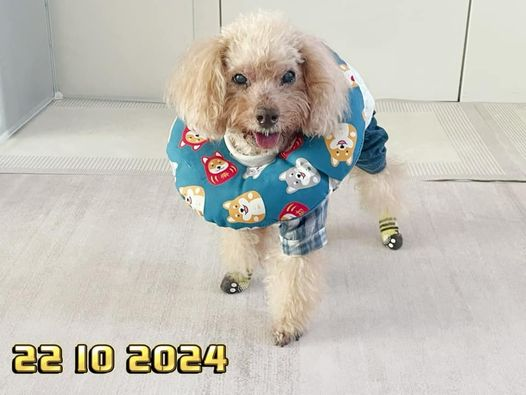

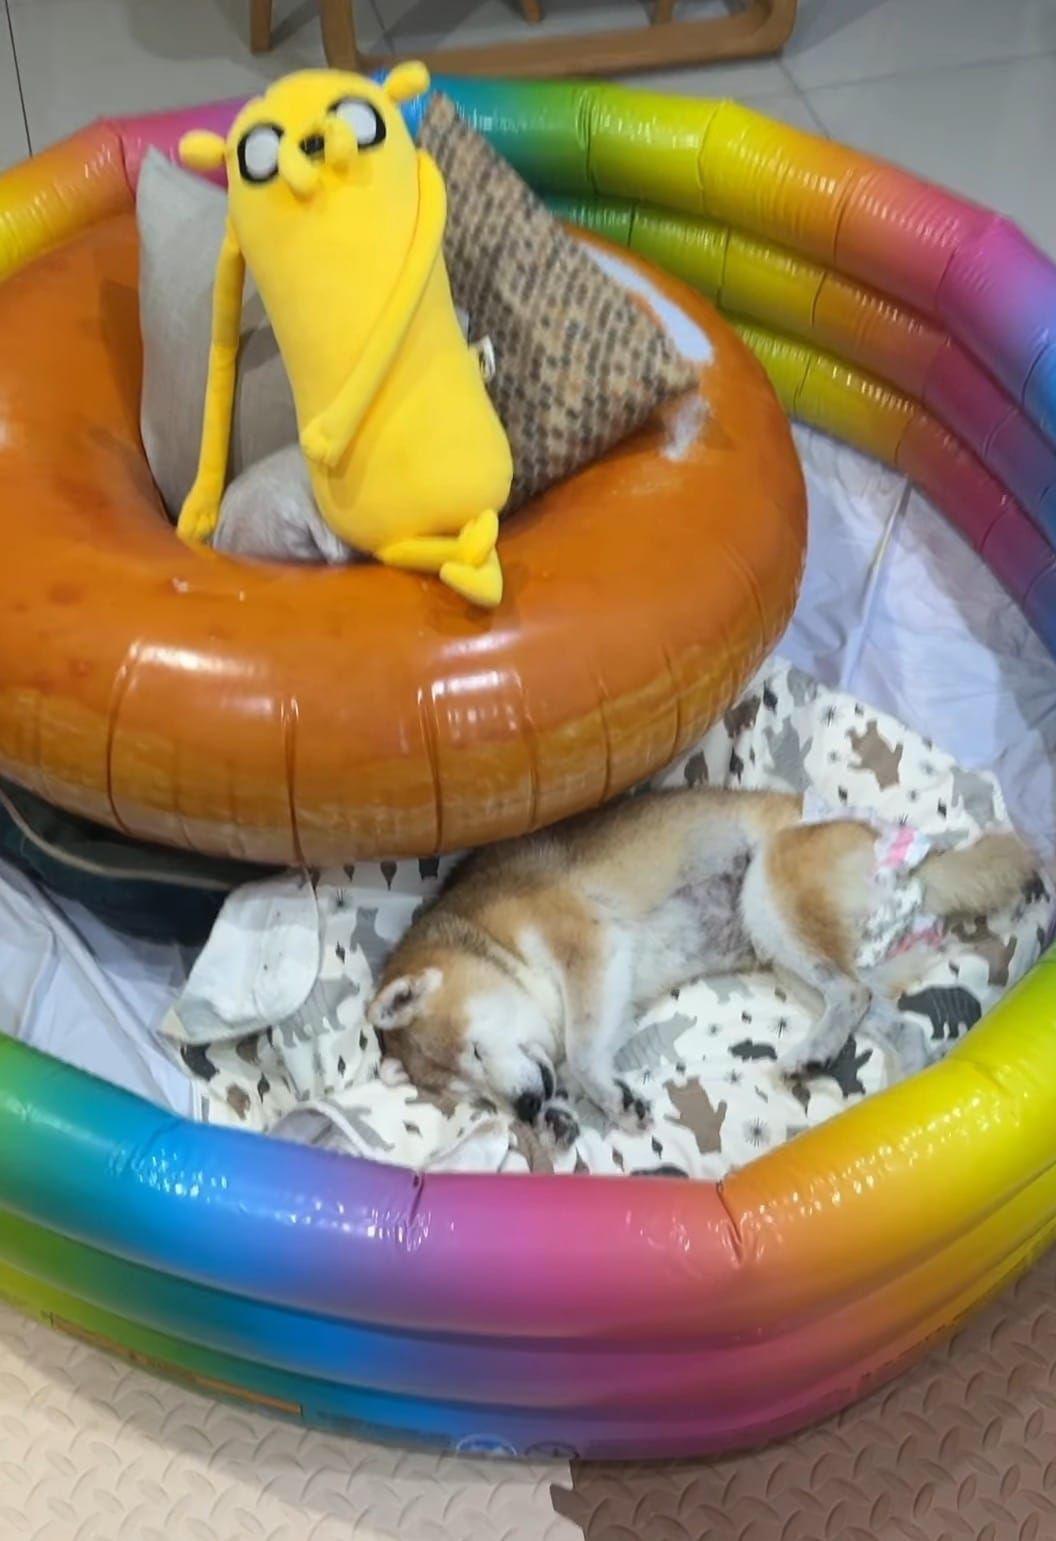

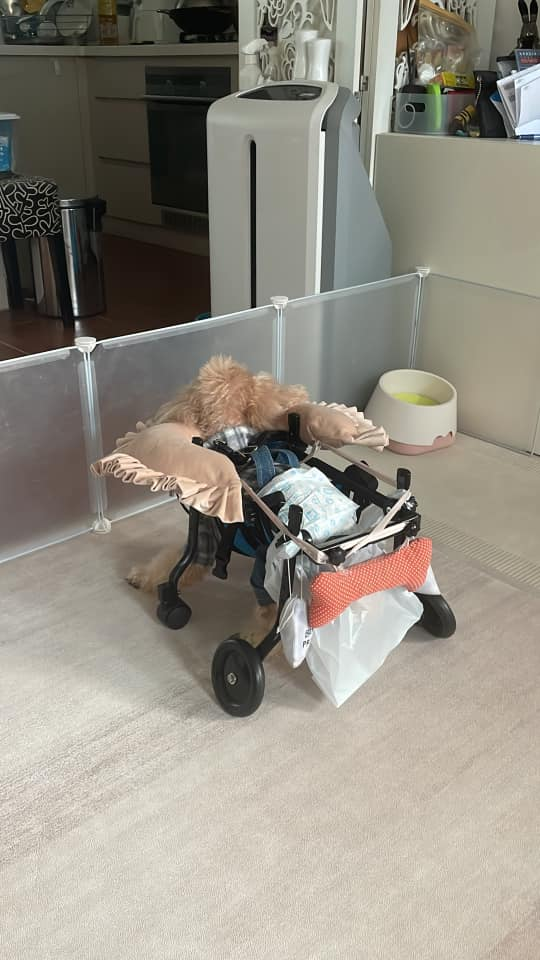

INFO:__main__:Image relevance score for query '老狗失智症有什麼症狀？': 0.15



Gemini的回答：
 您好，很高興為您解答。

根據您提供的圖片和資訊，我認為您可以嘗試以下幾種方法來改善狗狗的睡眠：

1. 在狗狗的睡覺區域放置一個舒適的床墊或毯子，讓牠可以舒適地休息。
2. 在狗狗的睡覺區域播放一些輕柔的音樂，營造一個安靜放鬆的環境。
3. 在狗狗睡覺前帶牠出去散步或玩耍，讓牠在睡覺前感到疲倦。
4. 避免在狗狗睡覺時打擾牠。

如果您嘗試了以上方法後，狗狗的睡眠狀況仍然沒有改善，建議您諮詢獸醫師，以獲得更專業的建議。

以下是一些獸醫師的建議：

* 美國獸醫行為學家Dr. Karen Overall建議，可以讓狗狗在一個安全、安靜的環境中睡覺，並在睡覺前避免讓狗狗過度興奮。
* 獸醫師Dr. Sophia Yin建議，可以給狗狗服用褪黑激素來幫助牠們入睡。褪黑激素是一種天然的激素，可以幫助調節睡眠週期。
* 獸醫師Dr. Gary Landsberg建議，可以給狗狗服用抗焦慮藥物來幫助牠們放鬆和入睡。抗焦慮藥物可以幫助狗狗減少焦慮和不安的情緒，讓牠們更容易入睡。

如果您正在考慮給狗狗服用任何藥物，請務必諮詢獸醫師，以確保藥物對狗狗是安全的，並且不會與狗狗的其他藥物發生相互作用。

--------------------------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]
INFO:__main__:Image relevance score for query '晚上狗狗一直叫該怎麼辦？': 0.0


問題： 老狗失智症有什麼症狀？

Gemini的回答：
**犬隻認知功能障礙症 (CD) 症狀：**

* **方向迷失：**在熟悉的地方迷路或徘徊。
* **行為改變：**睡眠週期改變、活動力下降、焦慮或激動。
* **認知能力下降：**對指令反應遲鈍、訓練後的行為忘記或執行困難。
* **記憶力減退：**不認得熟悉的人或地方、忘記進食或排泄。
* **排泄問題：**在家中不當排泄、排便或排尿頻率或量增加。
* **異常行為：**踱步、吠叫、發抖、在角落或黑暗處躲藏。
* **感知障礙：**對光線、聲音或觸摸過度敏感或遲鈍。

**社群經驗輔助參考：**

* 嗅覺良好且喜愛零食的犬隻，可試玩藏寶遊戲，以刺激其認知能力。
* 白天增加活動量，讓犬隻疲倦後夜晚較易入睡。
* 使用頸圈保護，防止犬隻跌落受傷。

**照護建議：**

* 提供安全且熟悉的環境，避免環境變化。
* 維持犬隻的日常作息，包括餵食、散步和睡眠時間。
* 使用助行器或輪椅協助行動不便的犬隻。
* 進行定期獸醫檢查，監控犬隻的認知能力和整體健康。

**需要就醫評估的情況：**

* 症狀突然出現或惡化。
* 犬隻表現出疼痛、發燒或其他身體不適。
* 認知功能障礙症症狀對犬隻的生活品質產生顯著影響。

--------------------------------------------------



Batches: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


問題： 晚上狗狗一直叫該怎麼辦？

Gemini的回答：
**專業解釋**

狗狗發出吠叫聲是表達情感或表達需求的一種方式。當一隻狗狗在晚上持續吠叫時，可能是以下原因造成的：

* **焦慮或恐懼：**環境中的某些刺激，例如大聲的噪音、陌生的環境或分離，都可能導致焦慮或恐懼，从而引发吠叫。
* **分離焦慮：**當一隻狗狗在與其主人分離時感到焦慮，它可能會通過吠叫來表達其焦慮。
* **疼痛或不適：**疼痛或不適也可能是狗狗在晚上吠叫的一個原因。例如，關節炎、牙痛或其他健康問題可能會引起疼痛，从而表现出吠叫的形式。
* **認知功能障礙（痴呆症）：**患有認知功能障礙症的狗狗可能會經歷混亂和迷失方向，从而吠叫。
* **夜盲症：**夜盲症會導致視力下降，在黑暗中看東西有困難，這可能會 khiến狗狗感到焦慮或恐懼，並吠叫以尋求安慰。

**社群經驗**

* 讓狗狗白天參與更多的活動，例如散步或與其他狗狗玩耍，使其精疲力盡，晚上更容易入睡。
* 在晚上給狗狗一個平靜、舒適的地方睡覺，避免噪音或其他干擾。
* 尝试使用鎮靜劑，例如纈草或褪黑激素，以幫助狗狗放鬆。
* 對狗狗使用行為矯正的方法，例如正向強化或 clicker 訓練，可以幫助建立行為界限並預防不當的吠叫。

**照護建議**

* 確定引起狗狗吠叫的根本原因至關重要。請諮詢獸醫以排除任何潛在的醫療問題。
* 如果獸醫排除了任何醫療問題，則可以尋求行為主義者的幫助，制定行為修改計劃。
* 提供一個積極和支持性的環境，滿足狗狗的情感需求。
* 耐心和一致性在管理具有吠叫問題的狗狗時至關重要。

**就醫評估的情況**

如果狗狗吠叫持續且無法控制，或者伴有其他症狀，例如食慾不振、嗜睡或嘔吐，請立即尋求獸醫的幫助。這些症狀可能是嚴重健康問題的徵兆，需要及時治療。

--------------------------------------------------



In [24]:
# 初始化 QA 系統
qa_system = QASystem(
    embedding_processor=embedding_processor,
    project_id="high-tribute-438514-j7",  # 替換為你的 project ID
    location="us-central1"
)

# 測試查詢
test_queries = [
    "繞圈圈的狗有適合她活動的佈置嗎？",
    "老狗失智症有什麼症狀？",
    "晚上狗狗一直叫該怎麼辦？"
]

for query in test_queries:
    qa_system.display_response(query)

## 7. 互動式查詢介面

In [ ]:
from IPython.display import clear_output

def interactive_query():
    while True:
        query = input("請輸入您的問題 (輸入'quit'結束): ").strip()
        
        if query.lower() == 'quit':
            break
            
        clear_output(wait=True)
        qa_system.display_response(query)
        print("\n輸入新的問題或輸入'quit'結束")

# 啟動互動式查詢
interactive_query()